In [ ]:
import inspect
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

#1 Prepare Data

##1.1 Import

In [ ]:
# Connect to the `MongoDB` server
client = MongoClient(host="localhost", port= 27017)
db = client["Air-Quality"]
dar = db["dar-es-salaam"]

In [ ]:
def wrangle(collection):
   results = collection.find(
       {"metadata.site": 11, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
   )
   # Read data into DataFrame
   df = pd.DataFrame(list(results)).set_index("timestamp")

   # Localize timezone
   df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")

   # Remove outliers
   df = df[df["P2"] < 100]

   # Resample to 1hr window
   y = df["P2"].resample("1H").mean().fillna(method='ffill')

   return y

In [ ]:
y = wrangle(dar)
y.tail()

timestamp
2018-03-12 22:00:00+03:00    26.432308
2018-03-12 23:00:00+03:00    24.834231
2018-03-13 00:00:00+03:00    25.036176
2018-03-13 01:00:00+03:00    26.094722
2018-03-13 02:00:00+03:00    42.139189
Freq: H, Name: P2, dtype: float64

## 1.2 Explore

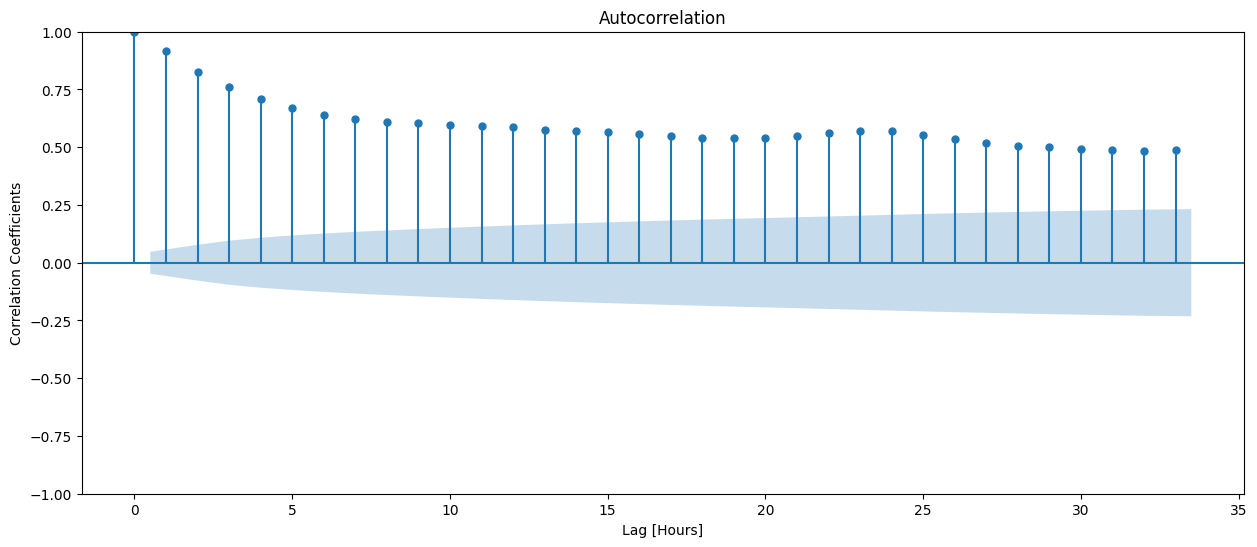

In [ ]:
# ACF plot
fig, ax = plt.subplots(figsize= (15,6))
plot_acf(y, ax = ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficients");

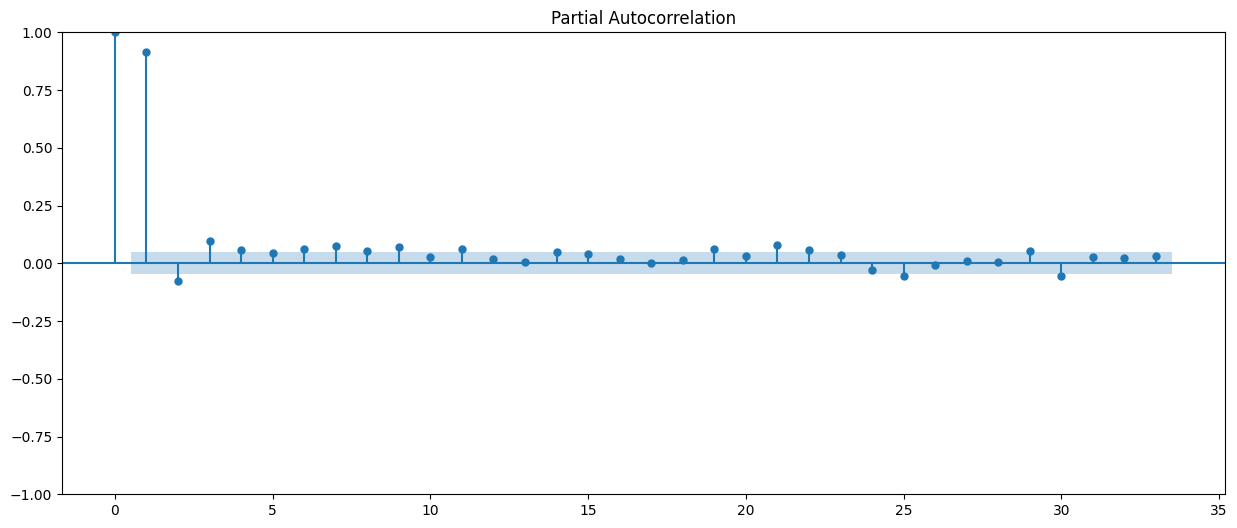

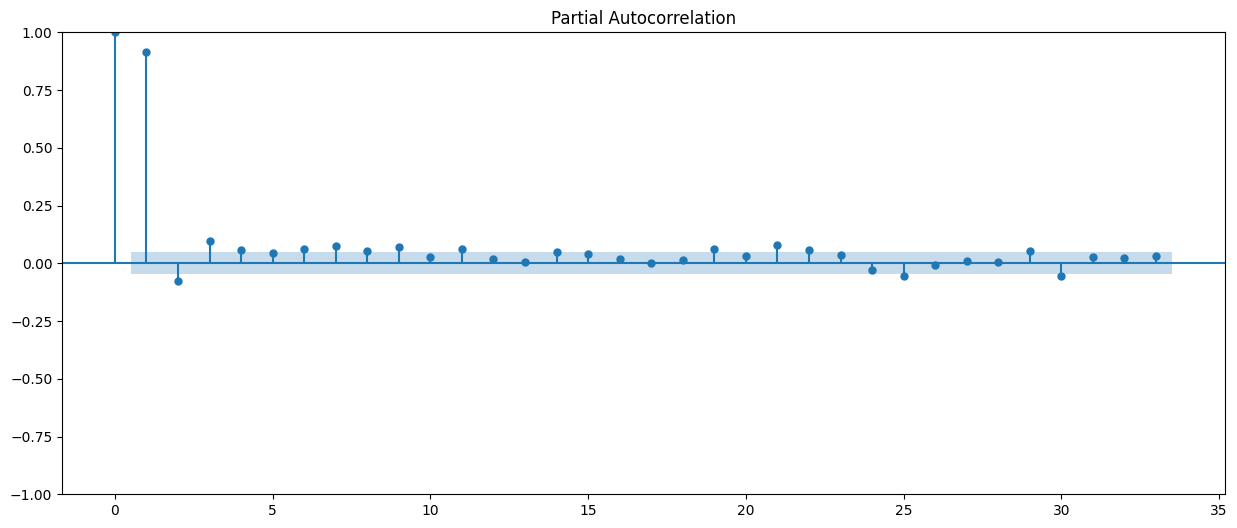

In [ ]:
# PACF plot
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(y, ax=ax)

## 1.3 Split

In [ ]:
#  Split `y` into training and test
cutoff_test = int(len(y) * 0.90)
y_train = y.iloc[: cutoff_test]
y_test = y.iloc[cutoff_test : ]

# 2 Build Model
## 2.1 Baseline

In [ ]:
# The baseline mean absolute error
y_train_mean= y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline= mean_absolute_error(y_train, y_pred_baseline)
print("Mean PM2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean PM2 Reading: 8.62
Baseline MAE: 4.08


## 2.2 Iterate

In [ ]:
# Create ranges for possible p and q values
p_params = range(0,25,8)
q_params = range(0,3,1)

In [ ]:
# Train a model with every combination of hyperparameters in `p_params` and `q_params`
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
     # Create key-value pair in dict. Key is `p`, value is empty list.
     mae_grid[p] = list()
     # Inner loop: Iterate through possible values for `q`
     for q in q_params:
           # Combination of hyperparameters for model
           order = (p, 0, q)
           # Note start time
           start_time = time.time()
           # Train model
           model = ARIMA(y_train, order=order).fit()
           # Calculate model training time
           elapsed_time = round(time.time() - start_time, 2)
           print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
           # Generate in-sample (training) predictions
           y_pred = model.predict()
           # Calculate training MAE
           mae = mean_absolute_error(y_train, y_pred)
           # Append MAE to list in dictionary
           mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.71 seconds.
Trained ARIMA (0, 0, 1) in 1.04 seconds.
Trained ARIMA (0, 0, 2) in 2.38 seconds.
Trained ARIMA (8, 0, 0) in 3.04 seconds.
Trained ARIMA (8, 0, 1) in 4.94 seconds.
Trained ARIMA (8, 0, 2) in 8.05 seconds.
Trained ARIMA (16, 0, 0) in 5.18 seconds.
Trained ARIMA (16, 0, 1) in 7.06 seconds.
Trained ARIMA (16, 0, 2) in 20.34 seconds.
Trained ARIMA (24, 0, 0) in 17.69 seconds.
Trained ARIMA (24, 0, 1) in 15.4 seconds.
Trained ARIMA (24, 0, 2) in 62.83 seconds.

{0: [4.076587214035632, 2.366751699853907, 1.735701303235268], 8: [0.9149709392455311, 0.9124927824368807, 0.9145130160893997], 16: [0.9126393083824447, 0.9125367002430539, 0.9125784812112455], 24: [0.9090586101443251, 0.9102660618683764, 0.9120609128872486]}


In [ ]:
# Organize all the MAE’s from above in a DataFrame names `mae_df`
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,4.0766,0.9150,0.9126,0.9091
1,2.3668,0.9125,0.9125,0.9103
2,1.7357,0.9145,0.9126,0.9121


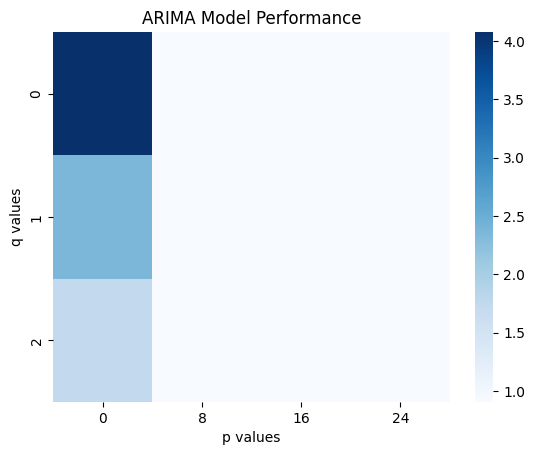

In [ ]:
# Heatmap of the values in mae_grid
sns.heatmap(mae_df, cmap = "Blues")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARIMA Model Performance");

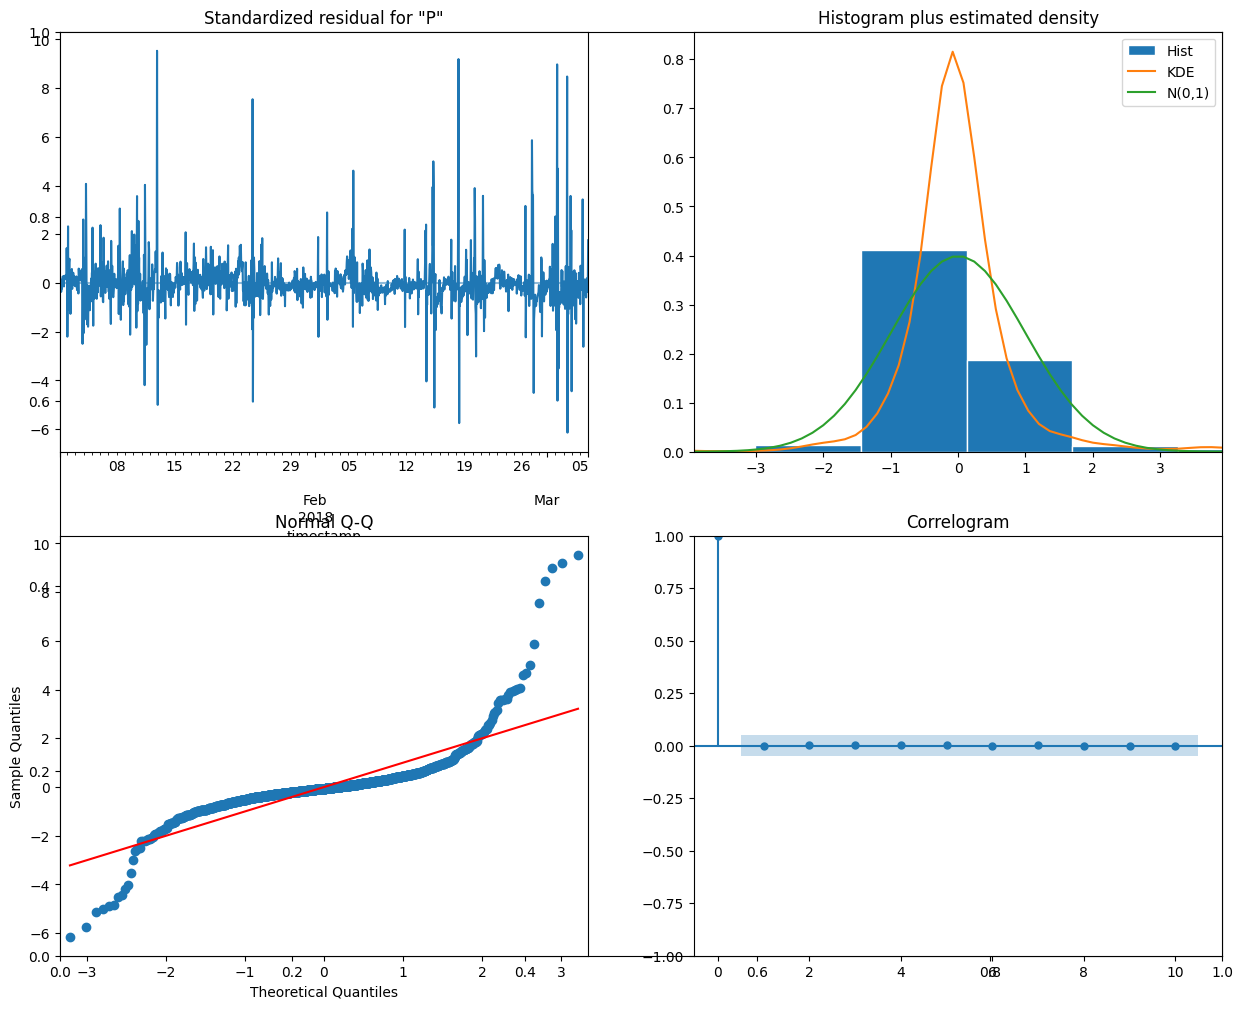

In [ ]:
# Check the residuals for our model
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);

In [ ]:
# Perform walk-forward validation for our model
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
     model = ARIMA(history, order=(8,0,1)).fit()
     next_pred = model.forecast()
     y_pred_wfv = y_pred_wfv.append(next_pred)
     history = history.append(y_test[next_pred.index])

In [ ]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.34


# 3 Communicate Results

In [ ]:
df_predictions = pd.DataFrame({"y_test": y_test,"y_pred_wfv": y_pred_wfv})
fig = px.line(df_predictions, labels = {"value": "PM2.5"})
fig.show()